# Mapping the 2021 La Palma *Cumbre Vieja* Eruption

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interact

import lplm_geoprocessing as lpgeo
import lplm_io as lpio
import lplm_presentation as lpp
import lplm_utils as lpu
import lplm_eda as lpe

In [2]:
# Run this to reload custom modules after making changes 
import importlib
importlib.reload(lpgeo)
importlib.reload(lpio)
importlib.reload(lpp)
importlib.reload(lpu)
importlib.reload(lpe)

<module 'lplm_eda' from '/home/jovyan/lplm/lplm_eda.py'>

Start our journey...

In [3]:
# Map inputs needs to be passed in as EPSG:4326 even though map CRS is EPSG:3857. 
map_center = ( (28.58 + 28.65) / 2, (-17.97 + -17.84) / 2)
 
from sidecar import Sidecar
from ipyleaflet import Map, LayersControl, projections
lp_map = Map(
    center=map_center,
    zoom=13,
    crs=projections.EPSG3857,
    scroll_wheel_zoom=True)
lp_map.add_control(LayersControl())
sc = Sidecar()
with sc:
    display(lp_map)

Load the image stack.

In [4]:
xds_grd = lpio.load_series("data")

## ❔ Choose an image

Inspect the images, and choose one to perform the analysis on.

Note that '2021-09-10' and '2021-09-16' are pre-event images.

In [5]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 100

selected_date = lpu.to_date('2021-11-15')

def view_scene(date=selected_date):
    # Use this date for the rest of the notebook
    global selected_date 
    
    layer_sar = lpp.make_sar_layer(xds_grd, date)
    lpp.replace_layer(lp_map, layer_sar, lpp.sar_layer_name(selected_date))
    selected_date = date
    
interact(view_scene, date=lpp.get_date_labels(xds_grd))

interactive(children=(Dropdown(description='date', index=10, options=(('2021-09-10', numpy.datetime64('2021-09…

<function __main__.view_scene(date=Timestamp('2021-11-15 00:00:00'))>

## Segmentation

SLIC

In [6]:
# This may take a little while.
lpgeo.apply_segmentation(xds_grd, selected_date)

gdf = lpgeo.vectorize_segments(xds_grd)

# Display results
from ipyleaflet import GeoData
# Have to convert to EPSG:4326 first, despite map CRS.
layer_seg = GeoData(
    geo_dataframe = gdf.to_crs("EPSG:4326"),
    style = { "fillOpacity": 0.0, "weight": 1.0 },
    name = "Segments")
lpp.replace_layer(lp_map, layer_seg)

## Analysis, Part 1

TODO: Reorder this - need to explain segmentation first?
To begin our attempt at lava classification, we rely on the observation that lava flows grow over time. That means if lava is present in a location on day 1, it will also be present on day 30. The nature, e.g., due to cooling, and volume may change, but should give us a baseline for subsequent measurements. 

Enrich - features... 

In [7]:
# This may take a little while.

# TODO: Split up into stats and derived calcs as before. ?

xds_segstats = lpgeo.segment_stats(xds_grd)

lpgeo.enrich(gdf, xds_segstats, selected_date)

layer_enriched = lpp.make_feature_layer(gdf, "local_lava_likeness")

lpp.replace_layer(lp_map, layer_enriched)

Sample...

In [8]:
# Choose sample area
from ipyleaflet import Polygon

layer_sample_poly = Polygon(
    name="Sample area - lava",
    locations=[
        (28.61279608, -17.90567758),
        (28.61279608, -17.88789544),
        (28.62486374, -17.88789544),
        (28.62486374, -17.90567758)
    ], transform=True)

lpp.replace_layer(lp_map, layer_sample_poly)

# Note: there seems to be a bug in ipyleaflet that leaves the handles after removing or hiding the layer.

Find matching segments.

In [9]:
from shapely import geometry

# Initial and manually-adjusted polygon have different point data layouts. So have to handle both.
try: # SHOULDDO: make this less hacky
    shapely_sample_4326 = geometry.Polygon([(pdict["lng"], pdict["lat"]) for pdict in layer_sample_poly.locations[0]])
except:
    shapely_sample_4326 = geometry.Polygon([(lon, lat) for (lat, lon) in layer_sample_poly.locations])
# gds_sample_3857 = geopandas.GeoSeries(shapely_sample_4326, crs="EPSG:4326").to_crs("EPSG:3857")
# For some reason, doing the intersection calc in EPSG:3857 doesn't always work - could be the point ordering in the polygon?
# So, as a workaround just do it in EPSG:4326.
gdf_4326 = gdf.to_crs("EPSG:4326")
gdf_sample_4326 = gdf_4326.loc[gdf_4326.intersects(shapely_sample_4326)]

# Display the result
from ipyleaflet import GeoData
layer_sample = GeoData(geo_dataframe=gdf_sample_4326, name="Sample segments - lava")
lpp.replace_layer(lp_map, layer_sample)

Pick a few segments from the sample (sub-sample) and inspect their distributions.

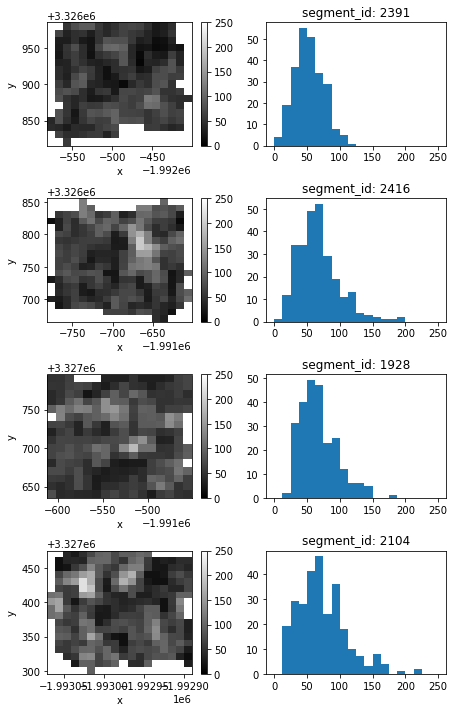

In [10]:
sample_segids = gdf_sample_4326["segment_id"].sample(4).values
lpe.plot_segment_histos(xds_grd, sample_segids, selected_date)

Look at the sample as a whole - the distribution of segment means and standard deviations.

(0.0, 128.0)

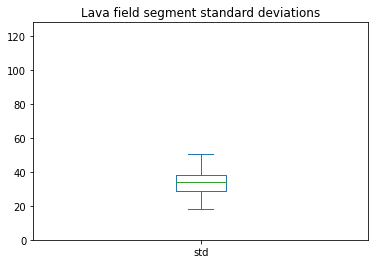

In [11]:
# TODO: Fix - can't run these together.
# gdf_sample_4326["mean"].plot.hist(bins=40, title="Lava field segment means", range=(0,255)); plt.xlabel("value")
# gdf_sample_4326["mean"].plot.box(title="Lava field segment means"); plt.ylim(0, 255)
# gdf_sample_4326["std"].plot.hist(bins=40, title="Lava field segment standard deviations", range=(0,255)); plt.xlabel("value")
gdf_sample_4326["std"].plot.box(title="Lava field segment standard deviations"); plt.ylim(0, 128)

Compare these with other land cover types... (TODO)

Calculate statistical features of segments, and from those derive initial lava-likeness metrics.

## Analysis, Part 2
Now we apply some neighbourhood-based operations to estimate the lava field.

### ❔ Choose a starting point

Choose a starting point to seed the region-growing algorithm - ideally somewhere clearly in the lava field.

In [12]:
from ipyleaflet import Marker
marker = Marker(location=map_center, draggable=True, name="Start")
lpp.replace_layer(lp_map, marker)

Find the matching segment.

In [13]:
from pyproj import Transformer
t = Transformer.from_crs("epsg:4326", "epsg:3857")
start_x, start_y = t.transform(marker.location[0], marker.location[1])
start_segment_id = lpgeo.get_segment_id(gdf, start_x, start_y)

Now, estimate the lava region.

In [14]:
# TODO: Fix warnings for this:
import warnings
warnings.filterwarnings('ignore')
lpgeo.lava_likeness_overall(gdf, start_segment_id)

gdf_lava_est = lpgeo.extract_lava_region(gdf, start_segment_id)

Show the results.

In [15]:
layer_neigh_ll = lpp.make_feature_layer(gdf, "neighbourhood_lava_likeness")

layer_lava = GeoData(
    geo_dataframe = gdf_lava_est.to_crs("EPSG:4326"),
    style = { "fillOpacity": 1.0, "weight": 1.0, "fillColor": "orange" },
    name = "Estimated lava field")

lpp.replace_layer(lp_map, layer_neigh_ll)
lpp.replace_layer(lp_map, layer_lava)

The Copernicus Emergency Rapid Mapping service provided maps through the course of the eruption. These were created with the aid of high resolution sources of various types, such as [COSMO-SkyMed](https://earth.esa.int/eogateway/missions/cosmo-skymed), a high resolution X-band SAR mission. See the [event page](https://emergency.copernicus.eu/mapping/ems/volcano-eruption-la-palma-spain) for further details. With a few of these as a reference, let's compare our results... 

In [16]:
import geopandas
ems_maps = {
    "2021-11-15": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT52_observedEventA_r1_v1.shp"),
    "2021-11-21": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT53_observedEventA_r1_v1.shp"),
    "2021-12-18": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT63_observedEventA_r1_v1.shp"),
}

def ems_layer_name(key):
    return f"EMS Rapid Mapping @ {key}"

def make_ems_layer(key):
    layer = GeoData(
        geo_dataframe = ems_maps[key].to_crs("EPSG:4326"),
        style = { "fillOpacity": 0.0, "weight": 1.0, "color": "red" },
        name = ems_layer_name(key))
    return layer

layers_ems = {}

for key in ems_maps.keys():
    layers_ems[key] = make_ems_layer(key)

selected_ems = None
    
def show_ems_layer(ems_map_date):
    global selected_ems
    lpp.replace_layer(lp_map, layers_ems[ems_map_date], ems_layer_name(selected_ems))
    selected_ems = ems_map_date
    return None
    
interact(show_ems_layer, ems_map_date=ems_maps.keys())

interactive(children=(Dropdown(description='ems_map_date', options=('2021-11-15', '2021-11-21', '2021-12-18'),…

<function __main__.show_ems_layer(ems_map_date)>